In [58]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import imutils

In [59]:
img = cv2.imread('test.png',0)
img2 = img[:]
template = cv2.imread('template.png',0)
w, h = template.shape[::-1]

In [60]:
res = cv2.matchTemplate(img,template,cv2.TM_CCORR_NORMED)

In [61]:
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

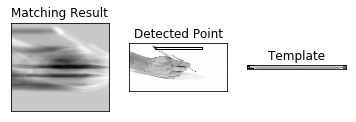

In [62]:
bottom_right = (max_loc[0] + w, max_loc[1] + h)

cv2.rectangle(img,max_loc, bottom_right, 0, 2)

plt.subplot(131),plt.imshow(res,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(template,cmap = 'gray')
plt.title('Template'), plt.xticks([]), plt.yticks([])

plt.show()

In [63]:
print max_loc,bottom_right,img.shape

(271, 56) (761L, 75L) (500L, 1024L)


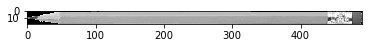

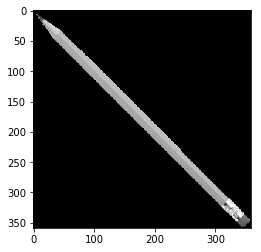

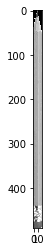

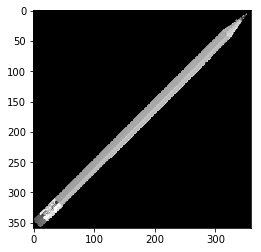

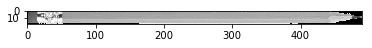

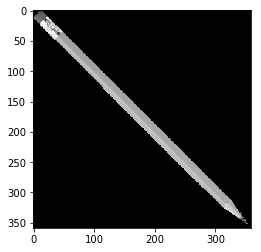

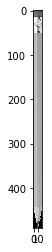

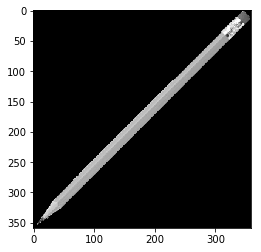

In [64]:
tmpts = []
tmpts.append(template)
rows,cols = template.shape

for i in range(45,360,45):
    tmpts.append(imutils.rotate_bound(template, i))

for t in tmpts:
    plt.imshow(t,cmap = 'gray')
    plt.show()

0.964410662651
0.277173578739
0.953414678574
0.278235375881
0.959173560143
0.277596265078
0.954117357731
0.27827078104


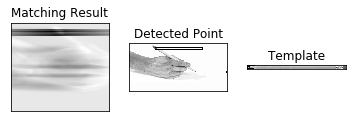

In [65]:
mv = 0
ml = [0,0]
tem = tmpts[0]
r = []

for t in tmpts:
    res = cv2.matchTemplate(img2,t,cv2.TM_CCORR_NORMED)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    print max_val
    if max_val > mv:
        mv = max_val
        ml = max_loc    
        tem = t
        r = res

w, h = tem.shape[::-1]
bottom_right = (ml[0] + w, ml[1] + h)

img3 = img2[:]
cv2.rectangle(img3,ml, bottom_right, 0, 2)

plt.subplot(131),plt.imshow(r,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img3,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(tem,cmap = 'gray')
plt.title('Template'), plt.xticks([]), plt.yticks([])

plt.show()

**Realized this type of matching does not work well for thin objects, should look for something closer to round/square so there is less outside boundary.**

**This is evident from the fact the that 2 diagonals which should have been the closest matches were by far the farthest from being a match.**

**Can this method be used to tell what brand a phone is?**

In [93]:
test = cv2.imread('test-1-i8.jpg',0)
sg8_f = cv2.imread('sg-8-f.jpg',0)
sg8_b = cv2.imread('sg-8-b.jpg',0)
ip8_f = cv2.imread('i8-f.jpg',0)
ip8_b = cv2.imread('i8-b.jpg',0)

In [94]:
#creates pyramids
def get_py(img,levels):
    imgs = []
    imgs.append(img)
    for i in range(levels-1):
        imgs.append(cv2.pyrDown(imgs[i]))
    return imgs

def get_rot(img):
    imgs = []
    imgs.append(img)
    for i in range(45,360,45):
        imgs.append(imutils.rotate_bound(img, i))
    for i in range(len(imgs)):
        imgs[i] = get_py(imgs[i],3)
    return imgs

Generate rotations of all templates and save them, than generate 3 levels of pyramids for all images. 

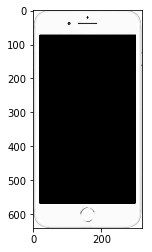

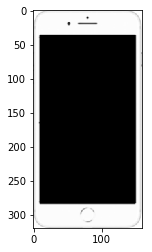

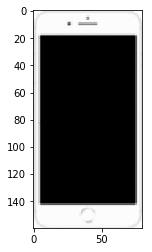

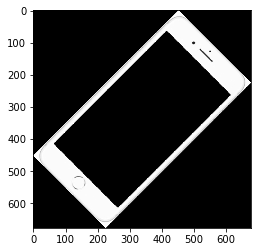

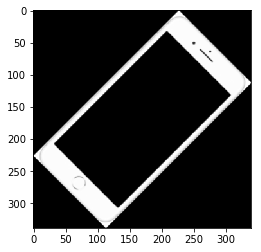

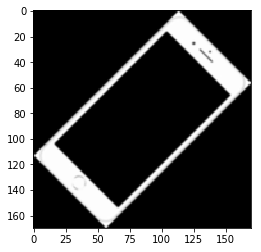

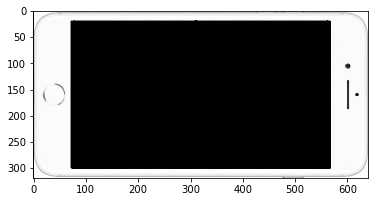

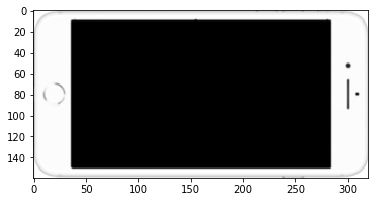

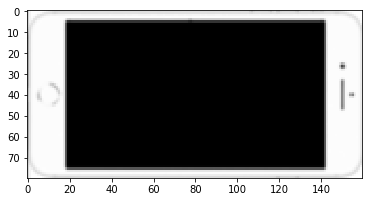

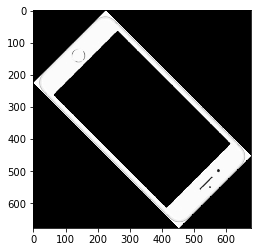

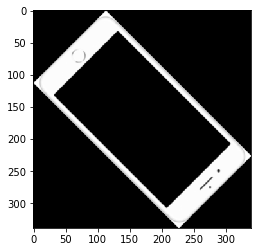

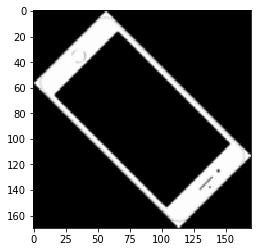

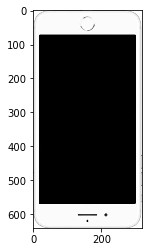

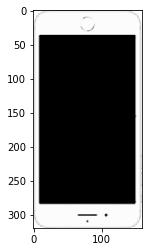

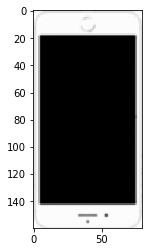

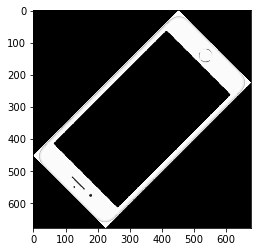

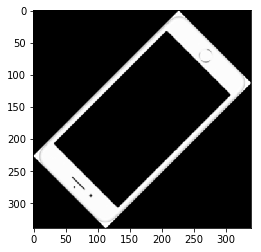

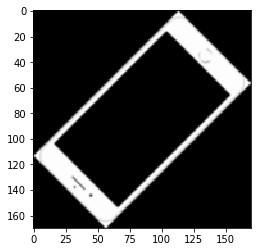

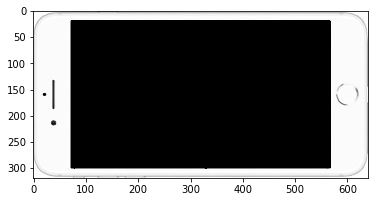

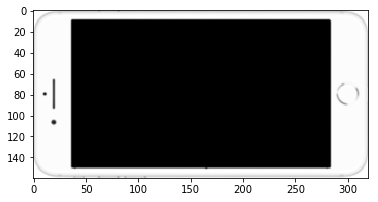

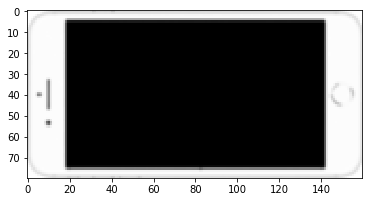

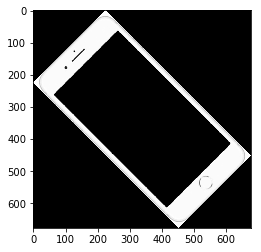

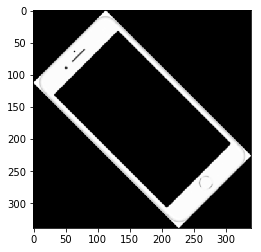

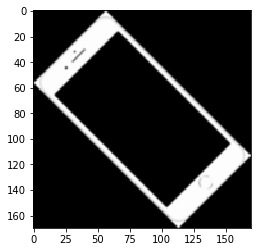

In [99]:
sg8_fP = get_rot(sg8_f)
sg8_bP = get_rot(sg8_b)
ip8_fP = get_rot(ip8_f)
ip8_bP = get_rot(ip8_b)
testP = get_py(test,3)

#conferm my algorithm works
for t in ip8_fP:
    for i in t:
        plt.imshow(i,cmap = 'gray')
        plt.show()


Now run every test image set on the test image, and display the best match, and the original

In [129]:
def get_score(tmpts,tests):
    mv = 0
    mtmp = [0,0]
    mtest = 0
    for ts in range(len(tmpts)):
        for t in range(len(tmpts[ts])):
            for test in range(len(tests)):
                if (tmpts[ts][t].shape[0] > tests[test].shape[0] or tmpts[ts][t].shape[1] > tests[test].shape[1]):
                    continue
                res = cv2.matchTemplate(tests[test],tmpts[ts][t],cv2.TM_CCORR_NORMED)

                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
                if max_val > mv:
                    mv = max_val
                    mtmp = [ts,t]
                    mtest = test
    return mv,mtmp,mtest

0.771539747715 0.485586673021


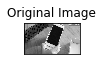

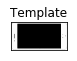

In [140]:
mv1,mtmp1,mtest1 = get_score(ip8_fP,testP)
mv2,mtmp2,mtest2 = get_score(sg8_fP,testP)

if mv1 > mv2:
    mtmp = mtmp1
    mtest = mtest1
else:
    mtmp = mtmp2
    mtest = mtest2

plt.figure(figsize=(1,1))
plt.imshow(testP[mtest],cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=(1,1))
plt.imshow(ip8_fP[mtmp[0]][mtmp[1]],cmap = 'gray')
plt.title('Template'), plt.xticks([]), plt.yticks([])
plt.show()

It figured out the correct phone type, but unfortunately it did not correctly orient the phone.

It's possible it was simply biased do to the size of this templace fitting well with the size of the original at this pyramid.

I also still have the issue from before where the angles versions have a lot of black in them which is likely lowering their scores, I assumed with the closer to square shape of a phone that would not be as much of an issue but It may be still.

One way to combat certain versions being naturally biased or unbiased is to simply build a network or algorithm to help decide what angle/phone is best based on myself selecting  a correct answer for each test photo.

The method I want to try first is a form of clustering algorithm where I will compare the res of each run with correct answer res's from other trials, and simply select the res that is the closest to other correct answers.

So I will be moving from ipynb to a normal python file so I can build a program to help me choose classifications by visual comparison. As for which pyramid to use, I will just take the best pyramid results for a given angle.